In [36]:
from collections import defaultdict
import json
import math
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
from tqdm import tqdm
import os
import requests
import torch
import torch.nn as nn
import sys

# Adjust display format for pandas
pd.options.display.float_format = '{:.2f}'.format

# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, LogisticModel

In [37]:
# Load models, X, Y, and datetimes to a file
data = np.load('./.cache/models_X_Y.npz', allow_pickle=True)
models, X, Y, datetimes = data['models'], data['X'], data['Y'], data['datetimes']

truncate = 50000
X = X[-truncate:]
Y = Y[-truncate:]
datetimes = datetimes[-truncate:]

# Subset to only the models with battles
idx_nonzero = np.abs(X).sum(axis=0) > 0

X = X.T[idx_nonzero].T
models = models[idx_nonzero]

In [38]:
X[3]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [39]:
print(np.abs(X).sum(axis=0))

[1993. 6533. 3279. 1075. 2081. 2933.  995. 4010. 2028. 3869. 2994. 2949.
 2484. 1999. 2115.  996.  972. 1067.  978. 1964. 2959. 3633. 1994. 6454.
 6756. 3311. 3230. 1048. 1135. 3158. 3068. 3140. 2954. 1071. 1017. 1154.
 1036. 2699. 2869.]


In [40]:
T = X.shape[0]
d = X.shape[1]
device = "cpu"
lrs = [0, 0.01, 0.1, 1]
experiment_name = "reg"

In [41]:
df_list = []
for lr in lrs:
    # Initialize the simple model
    model = LogisticModel(torch.zeros((d,)))

    # Define the mean squared error loss
    loss_fn = nn.BCELoss(reduction='sum')

    # Initialize the Gradient Descent optimizer
    optimizer = GD(model.parameters(), lr=lr, penalty_type="L1", lambda_=0.001)

    # Training loop
    thetas = torch.zeros(T+1, d, dtype=torch.float32)
    ys = torch.zeros(T+1, dtype=torch.float32)
    yhats = torch.zeros(T+1, dtype=torch.float32)
    losses = torch.zeros(T+1, dtype=torch.float32)
    gradients = torch.zeros(T+1, d, dtype=torch.float32)
    average_losses = torch.zeros(T+1, dtype=torch.float32)
    average_gradients = torch.zeros(T+1, d, dtype=torch.float32)
    model_a = [None, ]
    model_b = [None, ]

    model = model.to(device)

    for t in tqdm(range(T)):
        # Set up data
        x_t = torch.tensor(X[t], dtype=torch.float32)
        y_t = torch.tensor(Y[t], dtype=torch.float32)

        # Perform optimization
        optimizer.zero_grad()
        thetas[t+1] = model.theta.detach().cpu()
        prediction = model(x_t.to(device))
        loss = 0.5*loss_fn(prediction.squeeze(), y_t.to(device).squeeze())
        loss.backward()
        optimizer.step()

        # Store results
        ys[t+1] = y_t.detach().cpu()
        yhats[t+1] = prediction
        losses[t+1] = loss.detach().cpu().item()
        gradients[t+1] = model.theta.grad.detach().cpu()
        average_gradients[t+1] = gradients[:t+1].mean(dim=0)
        average_losses[t+1] = losses[:t+1].mean()
        model_a += [models[np.where(x_t==-1)[0][0]]]
        model_b += [models[np.where(x_t==1)[0][0]]]
        
    # Cache the thetas, ys, gradients, and norms in a pandas dictionary
    os.makedirs('.cache/' + experiment_name, exist_ok=True)
    df = pd.DataFrame({
        'theta': thetas.tolist(), 
        'y': ys.tolist(), 
        'yhat': yhats.tolist(), 
        'loss' : losses.tolist(), 
        'gradient': gradients.tolist(), 
        'average gradient': average_gradients.tolist(), 
        'average loss' : average_losses.tolist(),
        'model_a': model_a,
        'model_b': model_b
    })
    df.loc[1:,"datetime"] = datetimes

    df['lr'] = float(lr)
    df['d'] = d
    df_list += [df]

df = pd.concat(df_list, ignore_index=True)
df['norm of avg grad'] = df['average gradient'].apply(np.linalg.norm, ord=np.inf)
df.to_pickle('.cache/' + experiment_name + '/' + "0" + '.pkl')

100%|██████████| 50000/50000 [09:33<00:00, 87.16it/s] 


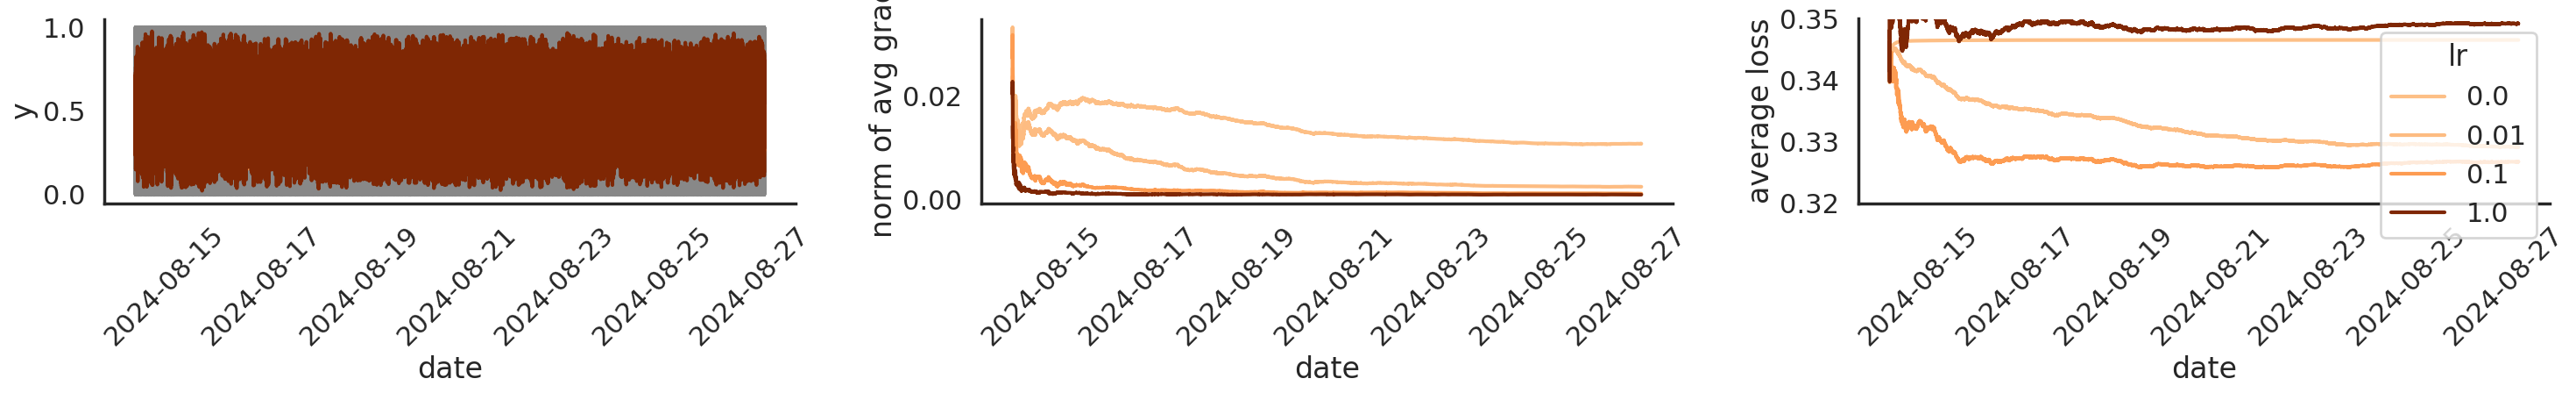

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

# Add burnin variable
burnin = 50  # Adjust this value as needed

# Create a color scale for the lr
lr_cmap_log = plt.colormaps["Oranges"]
lr_cmap = LinearSegmentedColormap.from_list("Custom", lr_cmap_log(np.logspace(-0.5, 1, 100, base=10)))

os.makedirs('./plots/' + experiment_name, exist_ok=True)

sns.set_style("white")
sns.set_context("poster")
sns.set_palette("pastel")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,5), sharex=True, sharey=False)

# Apply burnin to the dataframe
df_plot = df[df.datetime >= df[df.lr == 0].datetime.nsmallest(burnin).iloc[-1]]

# First, plot the ys, fs, and yhats on the same plot, to visually check the predictions.
sns.lineplot(ax=axs[0], data=df_plot[df_plot.lr == 0], x="datetime", y="y", color="#888888", estimator=None, n_boot=0)
_lp = sns.lineplot(ax=axs[0], data=df_plot, x="datetime", y="yhat", hue="lr", palette=lr_cmap, estimator=None, n_boot=0)
_lp.get_legend().remove()

# Next, plot the average gradient over time
_lp = sns.lineplot(ax=axs[1], data=df_plot, x="datetime", y="norm of avg grad", hue="lr", palette=lr_cmap, estimator=None, n_boot=0)
_lp.get_legend().remove()

# Next, plot the average loss over time
_lp = sns.lineplot(ax=axs[2], data=df_plot, x="datetime", y="average loss", hue="lr", palette=lr_cmap, estimator=None, n_boot=0)
_lp.get_legend().set_loc('upper right')

for tick in axs[0].get_xticklabels() + axs[1].get_xticklabels() + axs[2].get_xticklabels():
    tick.set_rotation(45)  # adjust the rotation angle as needed

sns.despine(top=True, right=True)

for ax in axs: 
    ax.set_xlabel("date")

ylims_avg_grad_1 = axs[1].get_ylim()
axs[2].set_ylim([0.32, 0.35])


plt.tight_layout()

plt.savefig('./plots/' + experiment_name + "/" + "series_with_burnin.pdf")
plt.show()

In [43]:
models

array(['athene-70b-0725', 'chatgpt-4o-latest',
       'claude-3-5-sonnet-20240620', 'claude-3-haiku-20240307',
       'claude-3-opus-20240229', 'deepseek-coder-v2-0724',
       'deepseek-v2-api-0628', 'gemini-1.5-flash-8b-exp-0827',
       'gemini-1.5-flash-api-0514', 'gemini-1.5-flash-exp-0827',
       'gemini-1.5-pro-api-0514', 'gemini-1.5-pro-exp-0801',
       'gemini-1.5-pro-exp-0827', 'gemma-2-27b-it', 'gemma-2-2b-it',
       'gemma-2-9b-it', 'gpt-4-0125-preview', 'gpt-4-0613',
       'gpt-4-1106-preview', 'gpt-4-turbo-2024-04-09',
       'gpt-4o-2024-05-13', 'gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18',
       'grok-2-2024-08-13', 'grok-2-mini-2024-08-13', 'jamba-1.5-large',
       'jamba-1.5-mini', 'llama-3-70b-instruct', 'llama-3-8b-instruct',
       'llama-3.1-405b-instruct', 'llama-3.1-70b-instruct',
       'llama-3.1-8b-instruct', 'mistral-large-2407',
       'mixtral-8x22b-instruct-v0.1', 'phi-3-medium-4k-instruct',
       'phi-3-mini-4k-instruct-june-2024', 'qwen2-72b-ins

# TODO:

* Model-wise calibration
$1/{|T_m|}\sum\limits_{t \in T_m} y_t - p_t(x_t) \to 0$.

* Pairwise calibration (same but with $T_{m, m'}$)

* Debiased LLM-as-a-judge

* Make a scatterplot of loss vs gradient error tradeoff for different learning rates.

[21, 2, 29, 12, 31]


/tmp/ipykernel_974899/3412817207.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(idxs_to_plot)))


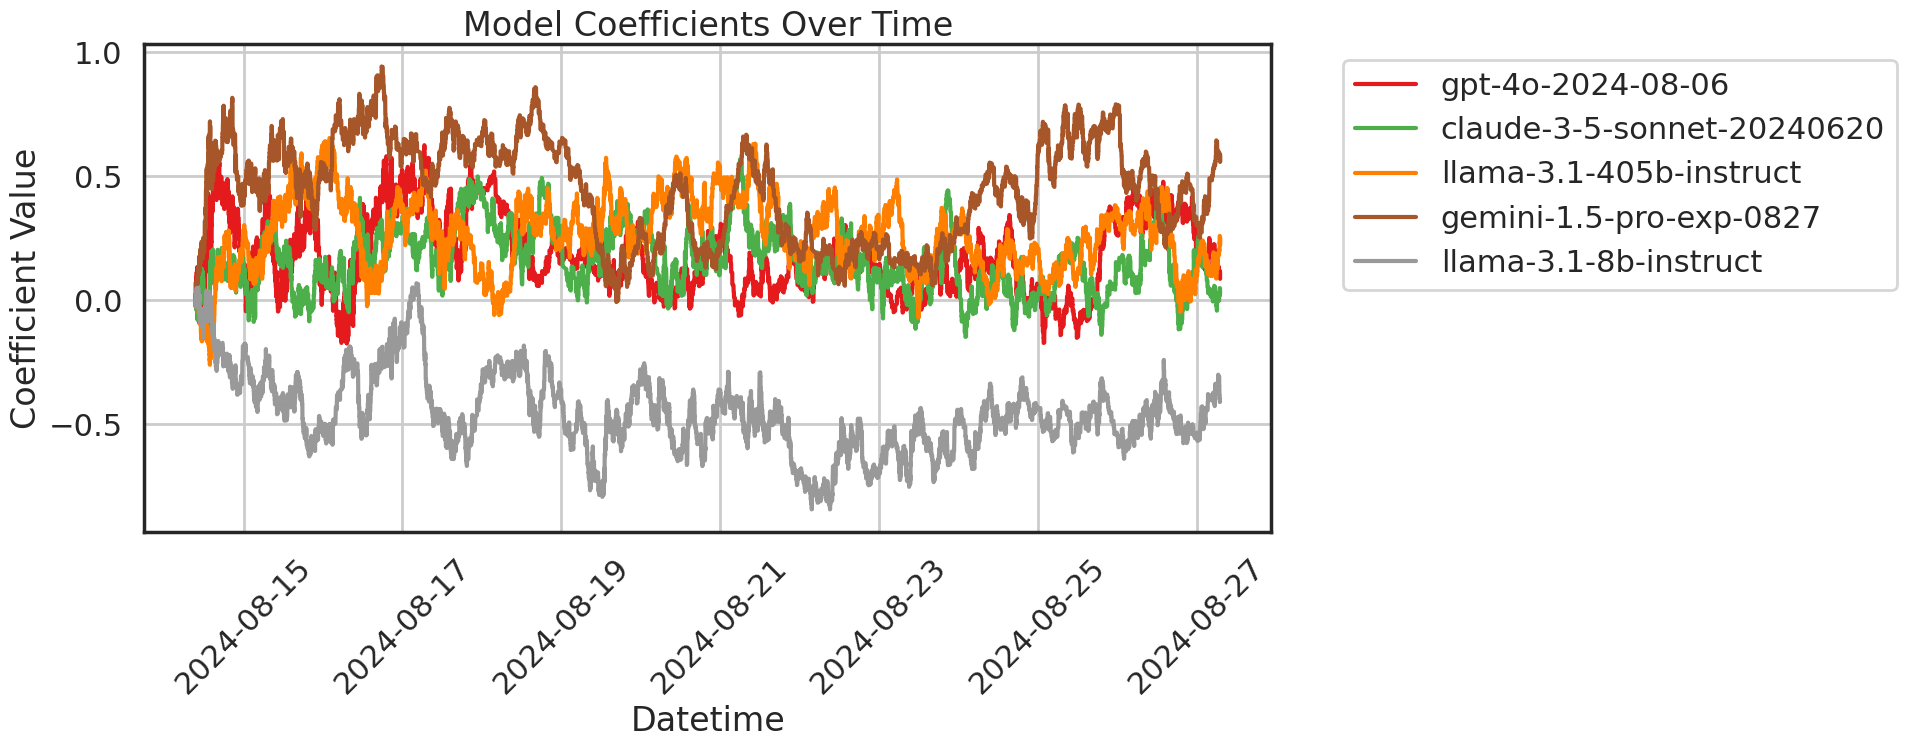

In [45]:
# Filter for lr=0.1
df_filtered = df[df.lr == 0.1]

models_to_plot = [
    'gpt-4o-2024-08-06',
     'claude-3-5-sonnet-20240620',
     'llama-3.1-405b-instruct',
     'gemini-1.5-pro-exp-0827',
     'llama-3.1-8b-instruct'
]

idxs_to_plot = [
    np.where(models == m)[-1][0] for m in models_to_plot
]
print(idxs_to_plot)

# Set up the plot
plt.figure(figsize=(20, 8))

# Color cycle for different models
color_cycle = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(idxs_to_plot)))

# Plot coefficients for each of the models
for i, model_idx in enumerate(idxs_to_plot):
    # Extract coefficients for this model
    coefficients = df_filtered.theta.apply(lambda x : x[model_idx])
    
    # Plot each coefficient
    plt.plot(df_filtered['datetime'], coefficients, 
                label=f'{models[model_idx]}', 
                color=color_cycle[i], 
                linestyle='-')  # Cycle through line styles
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(45)  # adjust the rotation angle as needed


plt.xlabel('Datetime')
plt.ylabel('Coefficient Value')
plt.title('Model Coefficients Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)

# Save the plot
plt.savefig('./plots/' + experiment_name + "/" + "elos.pdf")
plt.show()
